# Loading the dataset

In [2]:
import pandas as pd

In [9]:
data=pd.read_csv("customer_booking.csv", encoding='latin1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [8]:
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Data Analysis and Cleaning

### Checking null values

In [10]:
missing_summary = data.isnull().sum()
print(missing_summary)

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


### Checking duplicate rows

In [11]:
# Check for duplicates
print("Number of duplicate rows:", data.duplicated().sum())


Number of duplicate rows: 719


In [12]:

# Drop duplicates
data = data.drop_duplicates()

In [13]:
print("Number of duplicate rows:", data.duplicated().sum())

Number of duplicate rows: 0


In [14]:
# Inspect data types
print(data.dtypes)

# Convert columns to appropriate types if necessary
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
for col in categorical_columns:
    data[col] = data[col].astype('category')


num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object


### Removing outliers

In [16]:
# Detect outliers using IQR
numerical_columns = [
    'num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration'
]

outliers = {}
for col in numerical_columns:
    # Calculate Q1, Q3, and IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

# Display outliers for each column
for col, outlier_data in outliers.items():
    print(f"Outliers in column '{col}': {len(outlier_data)} rows")

# Combine all outlier indices to drop
all_outlier_indices = set()
for col, outlier_data in outliers.items():
    all_outlier_indices.update(outlier_data.index)

# Remove outliers
print(f"Total outliers across all columns: {len(all_outlier_indices)}")
data_cleaned = data.drop(index=all_outlier_indices)

# Display new dataset shape
print(f"Original dataset shape: {data.shape}")
print(f"Cleaned dataset shape: {data_cleaned.shape}")


Outliers in column 'num_passengers': 2851 rows
Outliers in column 'purchase_lead': 3391 rows
Outliers in column 'length_of_stay': 3748 rows
Outliers in column 'flight_hour': 0 rows
Outliers in column 'wants_extra_baggage': 0 rows
Outliers in column 'wants_preferred_seat': 0 rows
Outliers in column 'wants_in_flight_meals': 0 rows
Outliers in column 'flight_duration': 0 rows
Total outliers across all columns: 9379
Original dataset shape: (49281, 14)
Cleaned dataset shape: (39902, 14)


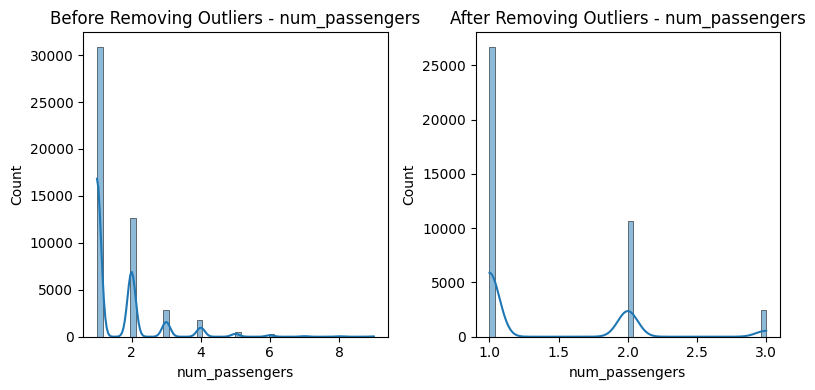

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot before and after outlier removal for 'num_passengers'
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Before outlier removal
sns.histplot(data['num_passengers'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Before Removing Outliers - num_passengers')

# After outlier removal
sns.histplot(data_cleaned['num_passengers'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('After Removing Outliers - num_passengers')

plt.tight_layout()
plt.show()


# Building the model

In [21]:
from sklearn.model_selection import train_test_split


X = data_cleaned.drop(columns=['booking_complete'])
y = data_cleaned['booking_complete']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (31921, 13)
Testing set shape: (7981, 13)


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define numerical and categorical columns
numerical_columns = [
    'num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration'
]
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flight_meals',
                                                   'flight_duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Evaluation metrices

Accuracy: 0.8450068913669966
ROC-AUC: 0.780210559901737

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91      6745
           1       0.50      0.11      0.18      1236

    accuracy                           0.85      7981
   macro avg       0.68      0.54      0.55      7981
weighted avg       0.80      0.85      0.80      7981



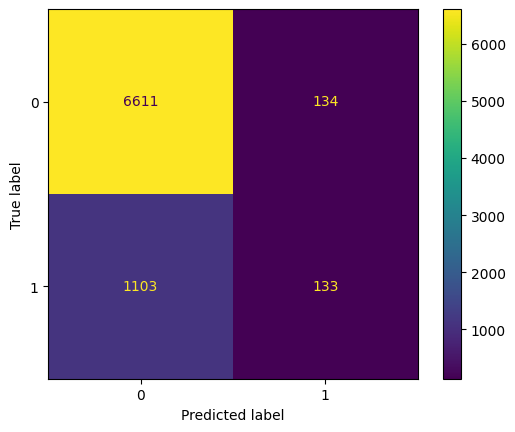

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


### Feature Importance

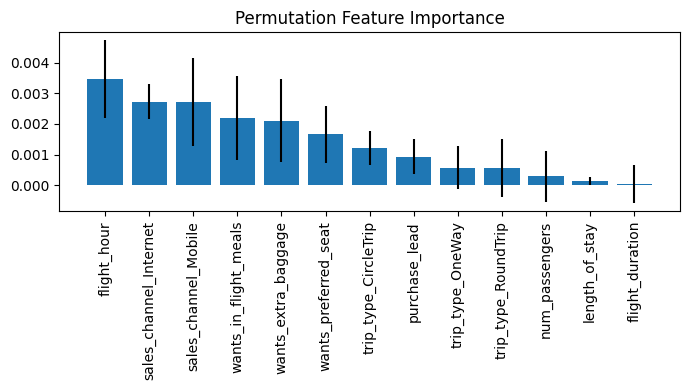

In [26]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(model_pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Get the importance and the corresponding feature names
importance_scores = perm_importance.importances_mean
std_scores = perm_importance.importances_std

# Plot the feature importance using permutation method
indices = np.argsort(importance_scores)[::-1]
plt.figure(figsize=(7, 4))
plt.bar(range(len(importance_scores)), importance_scores[indices], yerr=std_scores[indices], align='center')
plt.xticks(range(len(importance_scores)), [feature_names[i] for i in indices], rotation=90)
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()
